### Kinds of Plots

- The "toddler" plot--all curves from all patients colored by case/control with data points for each sample (DONE)
- One curve (one color) for case/control with data points for each sample (DONE)
- One point for case/control at each location (average across sites)

### Tracks

- Promoter region / etc
- CpG islands
- GC content
- Expression?

### Zoom
Window at boundaries; then +/- 100; 1000; 10,000

### Color
https://cran.r-project.org/web/packages/ggsci/vignettes/ggsci.html

In [14]:
library(DSS)
library(Gviz)
library(tidyverse)
library(data.table)
library(ggsci)
library(parallel)
library(scales)
library(wiscR)

In [15]:

# user inputs
CHR <- "chr18"
GEN <- "hg38"
FS <- 18 # fontsize

#TODO: csv with chr,start,stop,Name 
# Then filter by chr matching our CHR
# supp.df <- read_csv()
idir <- paste0("./result-", CHR, "/")

roi.df <- read_csv("regions-of-interest.csv")
M <- fread(file.path(idir, "M.csv"))
Cov <- fread(file.path(idir, "Cov.csv"))
Meth <- fread(file.path(idir, "methylation.csv"))
load(file.path(idir, "test-values.RData"))

Rows: 2 Columns: 4

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): chr, name
dbl (2): start, end


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [16]:
NCOL <- 7
colors <- pal_nejm("default")(NCOL)
#show_col(colors)

In [17]:
df <- read_csv("../../data/meta/phenos-cleaned.csv")
#TODO: make parameters from command line...
valid_samples <- intersect(colnames(Meth)[-1], df$sample)
print(valid_samples)

filt.df <- df %>% filter(sample %in% valid_samples)

Rows: 83 Columns: 18

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): cohort, machine, pool, group, batch, sex
dbl (12): sample, CD8T, CD4T, NK, Bcell, Mono, Gran, charlson_score, bmi, wa...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



 [1] 131 154 144 120 167 185 188 109 126 166 142 146 111 145 159 164 105 100 129
[20] 112 125 147 115 104 170 110 108 107 136 161 143 148 174 158 116 132 134 186
[39] 140 127 114 130 122 133 156 139 101 119 123 137 118 138 141 169 106 157 165
[58] 163 135 113 168


In [18]:
dmrs <- callDMR(test.cohort, p.threshold=0.01, dis.merge = 2500, pct.sig = 0.5, minCG = 3)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



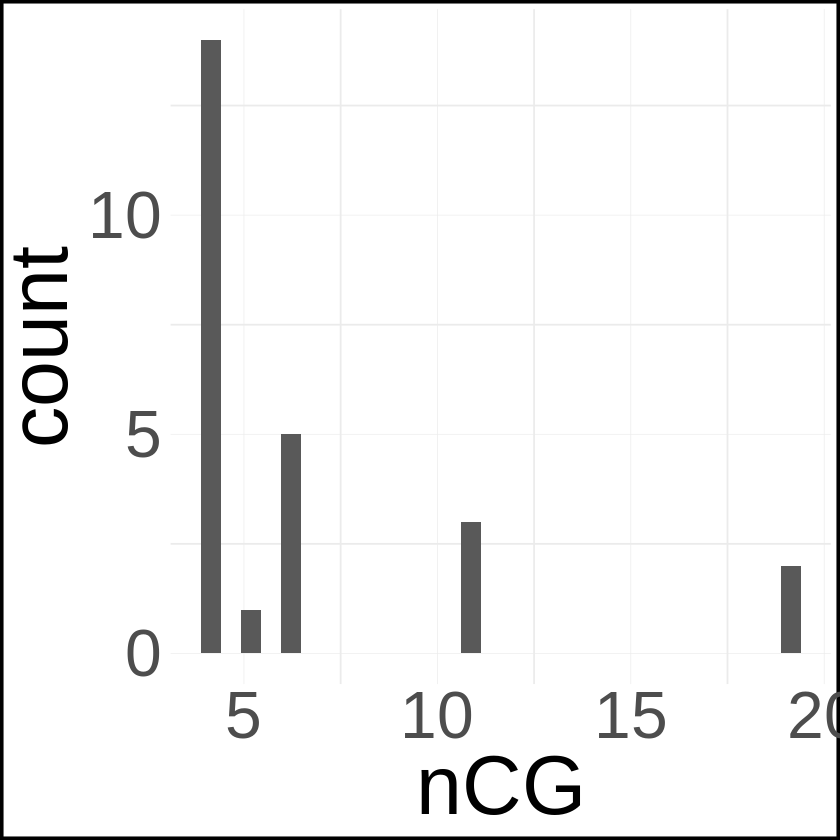

In [19]:
dmrs %>%
    ggplot(aes(x = nCG)) +
    geom_histogram() +
    wiscR::light_theme() 

# callDMR

Parameters that we can vary: 
- `p.threshold`
- `minlen` is the minimum length in bp to be considered a region (default 50)
- `minCG` (default 3)
- `dis.merge` if two DMRs are dis.merge or fewer basepairs apart then they are merged.
- `pct.sig` percentage of CG called significant

In [20]:
load.samples <- filt.df %>% filter(cohort == "AD") %>% pull(sample) %>% as.character()
control.samples <- filt.df %>% filter(cohort == "CONTROL") %>% pull(sample) %>% as.character()

In [21]:
length(load.samples)
length(control.samples)

[1] 33

[1] 28

In [22]:
prepare_granges <- function(DT, chr=CHR){
    # Munges dataframe (changes column names)
    # to be amenable to GRanges() constructor
    DT.2 <- DT
    
    colnames(DT.2)[colnames(DT.2) == "pos"] <- "start"
    DT.2$end <- DT.2$start + 2
    DT.2$chr <- chr
    return(DT.2)
}



make_difference_track <- function(Meth, load.samples, control.samples, chr = CHR){
    
    # Compute mean difference
    meandiff <- rowMeans(Meth[ , load.samples, with = FALSE], na.rm = TRUE) - 
            rowMeans(Meth[ , control.samples, with = FALSE], na.rm = TRUE)
    # Construct GRanges
    dt <- data.table(diff=meandiff, chr=CHR, start=Meth$start, end=Meth$end) %>%
            drop_na() # important to prevent errors
    gr <- GRanges(dt)
    track <- DataTrack(gr, type=c("p", "smooth"), baseline=0, col=colors[2],
                       col.baseline="black", name="Mean Methylation Difference", 
                       fontsize = FS)
    return(track)
} 


make_methylation_track <- function(Meth, group){
    # Meth matrix should have been run through 
    DataTrack(GRanges(Meth), 
              groups = group, 
              name = "Methylation",                             
              type = c("a", "p"), 
              legend = TRUE) %>%
    return()
}


make_cpg_track <- function(start, stop){
    cpgIslands <- UcscTrack(genome = GEN, chromosome = CHR, 
                        track = "cpgIslandExt", 
                        from = start, to = stop,
                        trackType = "AnnotationTrack", 
                        start = "chromStart", end = "chromEnd", 
                        id = "name", shape = "box", fill = colors[4], 
                        name = "CpG Islands", fontsize = FS)
    return(cpgIslands)
}


make_snp_track <- function(start, stop){
    
    snpLocations <-  UcscTrack(genome = GEN, chromosome = CHR, 
                           track = "snp141", 
                           from = start, to = stop,
                           trackType = "AnnotationTrack", 
                           start = "chromStart", end = "chromEnd", 
                           id = "name", feature = "func", 
                           strand = "strand", shape = "box", 
                           stacking = "dense", fill = colors[2],
                           name = "SNPs", fontsize = FS)
    return(snpLocations)
}

make_p_track <- function(test.cohort){
     # Meth matrix should have been run through 

    data.frame(chr = test.cohort$chr, start = test.cohort$pos, stop = test.cohort$pos + 2, 
               log.p = -1*log10(test.cohort$pvals)) %>%
        drop_na() %>%
        GRanges() %>%
        DataTrack(name = "-log10(p)", type = c("smooth", "p"), 
              legend = TRUE, col=colors[1], fontsize = FS) %>%
    return()
}




In [23]:
Meth.2 <- prepare_granges(Meth)
group <- filt.df$cohort[match(colnames(Meth)[-1], filt.df$sample)]

In [24]:
# "Simple" tracks without too many parameters
dmrs.track <- AnnotationTrack(GRanges(dmrs), genome = GEN, name = "DMRs", fontsize = FS,
                             fill = colors[3], col = "white")
ideogram.track <- IdeogramTrack(genome = GEN, chromosome = CHR, fontsize = FS - 2)
axis.track <- GenomeAxisTrack()
p.track <- make_p_track(test.cohort)

# Tracks from custom functions
diff.track <- make_difference_track(Meth.2, load.samples, control.samples)

# Show up on top of genomic information
top.list <- list(ideogram.track, axis.track)

# Show up below gneomic info
bottom.list <- list(dmrs.track, p.track, diff.track)

In [25]:
plot_all_tracks <- function(start, stop, top.tracks.list, bottom.tracks.list, 
                            odir, pad=c(100,1000, 10000)){
    # start : starting position
    # stop: stopping position
    # tracks_list: list of tracks to plot, produced beforehand
    # odir: where to save pngs
    # pad: vector specifying how big a window
    
    # File setup
    dir.create(odir, showWarnings=FALSE)
    
    # Make the genes track based on the largest window
    a <- start - max(pad)
    b <- stop + max(pad)
    
    # All the tracks
    ref.genes.track <- make_gene_track(start = a, stop = b)
    #snp.track <- make_snp_track(start = a, stop = b)
    cpg.track <- make_cpg_track(start = a, stop = b)
    
    # Cobble together
    mid.tracks.list <- list(ref.genes.track, cpg.track)
        
    # Loop thru padding values
    for (p in pad){
        a <- start - p
        b <- stop  + p
        
        tracks.list <- append(top.tracks.list, mid.tracks.list)
        tracks.list <- append(tracks.list, bottom.tracks.list)
        
        
        # Save, how do we feel about default sizes?
        pdf(paste0(odir, as.character(start), "-", as.character(p), "-DMRs.pdf"))
        plotTracks(tracks.list, from = a, to = b, 
                   background.title = colors[6])
        dev.off()
    }    
}

In [ ]:
ix <- 1
a <- dmrs$start[ix]
b <- dmrs$end[ix]

tmp <- make_gene_track(a, b)

#plot_all_tracks(a, b, top.list, bottom.list, file.path(idir, "figs/"))

In [ ]:
plot_by_ix <- function(ix){
    plot_all_tracks(dmrs$start[ix], dmrs$end[ix], top.list, bottom.list, file.path(idir, "figs/"))
}

mclapply(1:nrow(dmrs), plot_by_ix, mc.cores = 8)

# Regions of Interest

In [31]:
roi.df <-roi.df %>% filter(chr == CHR)
a <- roi.df$start[1] - 30000
b <- roi.df$end[1] + 30000


make_gene_track <- function(start, stop, gen=GEN, chr=CHR){
    # Produces the track with exons, 
    
    out <- UcscTrack(track = "GENCODE V38", name = "something",type="GeneRegionTrack",
                      genome = gen, chromosome = chr,
                      from = start, to = stop,
                      rstarts="thickStart", rends="thickEnd", 
                      gene="name", symbol="name", 
                      transcript="name", strand="strand",
                      transcriptAnnotation = "name", showID=TRUE)
    return(out)
} 

make_gene_track <- function(start, stop, gen=GEN, chr=CHR){
    # Produces the track with exons, 
    
    out <- UcscTrack(track = "knownGene", type="GeneRegionTrack",
                      genome = gen, chromosome = chr,
                      from = start, to = stop,
                      trackType = "GeneRegionTrack", 
                        rstarts = "exonStarts", rends = "exonEnds", 
                        gene = "name", symbol = "name", 
                        transcript = "name", strand = "strand", 
                        fill = "#8282d2", name = "UCSC Genes")
                    #transcriptAnnotation = "name2")
    return(out)
} 



tmp <- make_gene_track(a,b)
plotTracks(tmp,a,b)

#plot_all_tracks(, top.list, bottom.list, 
 #               file.path(idir, "figs/", paste0(roi.df$name[1], "/")),
  #              pad = c(1000, 3000, 5000))

Warning message in assign(i, as.numeric(val)):
"NAs introduced by coercion"
Warning message in assign(i, as.numeric(val)):
"NAs introduced by coercion"


ERROR: Error in .fillWithDefaults(data.frame(start = as.integer(start), end = as.integer(end)), : Number of elements in argument 'transcript' is invalid


In [ ]:
tmp

In [33]:
from <- 65921878
to <- 65980988

knownGenes <- UcscTrack(genome="mm9", chromosome="chrX", track="knownGene",
from=from, to=to, trackType="GeneRegionTrack",
rstarts="exonStarts", rends="exonEnds", gene="name",
symbol="name", transcript="name", strand="strand",
fill="#8282d2", name="UCSC Genes")

In [39]:
str(knownGenes)

Formal class 'GeneRegionTrack' [package "Gviz"] with 10 slots
  ..@ start     : num 65921878
  ..@ end       : num 6.6e+07
  ..@ stacking  : chr "squish"
  ..@ stacks    : num(0) 
  ..@ range     :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. ..@ values         : Factor w/ 1 level "chrX": 1
  .. .. .. .. ..@ lengths        : int 76
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. .. .. ..@ start          : int [1:76] 65920688 65926493 65930188 65931354 65931729 65941456 65944675 65931729 65941456 65944675 ...
  .. .. .. .. ..@ width          : int [1:76] 2355 58 113 221 314 54 995 314 54 95 ...
  .. .. .. .. ..@ NAMES          : NULL
  .. .. .. .. ..@ elementType    : chr "ANY"
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : l

In [44]:
length(identifier(knownGenes))

[1] 76

In [40]:
str(tmp)

Formal class 'GeneRegionTrack' [package "Gviz"] with 10 slots
  ..@ start     : num 75195108
  ..@ end       : num 75209506
  ..@ stacking  : chr "squish"
  ..@ stacks    : num(0) 
  ..@ range     :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. ..@ values         : Factor w/ 1 level "chr18": 1
  .. .. .. .. ..@ lengths        : int 4
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. .. .. ..@ start          : int [1:4] 75201415 75201415 75201716 75201877
  .. .. .. .. ..@ width          : int [1:4] 7644 766 465 304
  .. .. .. .. ..@ NAMES          : NULL
  .. .. .. .. ..@ elementType    : chr "ANY"
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ strand         :Formal class 'Rle' [package "S4Vectors"] with 4 s

In [41]:
identifier

new("standardGeneric", .Data = function (GdObject, ...) 
standardGeneric("identifier"), generic = "identifier", package = "Gviz", 
    group = list(), valueClass = character(0), signature = "GdObject", 
    default = NULL, skeleton = (function (GdObject, ...) 
    stop("invalid call in method dispatch to 'identifier' (no default method)", 
        domain = NA))(GdObject, ...))
<bytecode: 0x555c884967e8>
<environment: 0x555c86518900>
attr(,"generic")
[1] "identifier"
attr(,"generic")attr(,"package")
[1] "Gviz"
attr(,"package")
[1] "Gviz"
attr(,"group")
list()
attr(,"valueClass")
character(0)
attr(,"signature")
[1] "GdObject"
attr(,"default")
`\001NULL\001`
attr(,"skeleton")
(function (GdObject, ...) 
stop("invalid call in method dispatch to 'identifier' (no default method)", 
    domain = NA))(GdObject, ...)
attr(,"class")
[1] "standardGeneric"
attr(,"class")attr(,"package")
[1] "methods"

In [27]:
?identifier

In [26]:
GenomicRanges::

ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function 'identifier' for signature '"DataTrack"'


# Run Lengths

In [ ]:

# Pull mean difference data from trackj
mean.diffs <- as.vector(diff.track@data)
mean.diffs <- mean.diffs[!is.na(mean.diffs) & mean.diffs != 0]

# Run length embedding tells about the runs themselves
embedded <- rle(sign(mean.diffs))
tmp.df <- data.frame(sign = as.factor(embedded$values), run_length = embedded$lengths * embedded$values)

In [ ]:
longest.run <- max(embedded$lengths)
median.run <- median(embedded$lengths)

LOAD.greater <- sum(mean.diffs > 0)
CONT.greater <- sum(mean.diffs < 0)

What is the probability of this?

In [ ]:
p <- tmp.df %>%
    ggplot(aes(x = run_length)) +
    geom_freqpoly() +
    xlab("Run length") +
    scale_y_log10() +
    xlim(c(-1*longest.run, longest.run)) +
    wiscR::light_theme() +
    geom_vline(xintercept = 0, color = "red")

p
wiscR::save_plot(p, ofile = file.path(idir, "figs/run-lengths.png"))

In [ ]:
random.sample <- sample(c(-1, 1), replace=TRUE, 1e6)

In [ ]:
# Run length embedding tells about the runs themselves
embedded <- rle(sign(random.sample))
tmp.df <- data.frame(sign = as.factor(embedded$values), run_length = embedded$lengths * embedded$values)

tmp.df %>%
    ggplot(aes(x = run_length)) +
    geom_freqpoly() +
    xlab("Run length") +
    scale_y_log10() +
    xlim(c(-1*longest.run, longest.run)) +
    wiscR::light_theme() +
    geom_vline(xintercept = 0, color = "red")

Since it's `LOAD - Control`, we've got roughly 850,000 positions where LOAD methylation is greater, and 680,000 positions where Control methylation is greater. Is this percentage consistent across chromosomes?